In [1]:
import json
import pandas as pd
import numpy as np
import time
import gcsfs
import datetime
from google.cloud import storage 
from google.cloud import bigquery
from pathlib import Path
import os

In [2]:
PROJ_ROOT = Path().resolve().parent
KEYS_DIR = PROJ_ROOT / 'keys' 
keys = KEYS_DIR / 'Keys for Big Query Storage Admin - PEII.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(keys)

In [3]:
project = 'peii-242723'
today = datetime.datetime.now().date() - datetime.timedelta(days=1)
print('Today is', today)

# Setup Storage vars
storage_client = storage.Client(project=project)
bucket = storage_client.get_bucket('impact-index-shared-resources')

# Setup BigQuery vars
bq_client = bigquery.Client()
dataset_id = 'entrepreneur_data'
dataset_ref = bq_client.dataset(dataset_id, project=project)

# # Setup Pub/Sub vars
# publisher = pubsub_v1.PublisherClient()
# topic_name = "trigger_process_entrepreneur_data_topic"
# topic_path = publisher.topic_path(project, topic_name)


def export_bq_table(table_id):
    """
    Exports a particular table in BigQuery to the interim
    folder in data in Storage.
    """
    # Setup table reference
    table_ref = dataset_ref.table(table_id)
    
    # Export data
    destination_uri = 'gs://{}/{}/{}/{}/{}.csv'.format(
        'impact-index-shared-resources', 'data', 'interim', today, table_id
    )
    extract_job = bq_client.extract_table(
        table_ref,
        destination_uri,
        # Location must match that of the source table.
        location='US',
    )  # API request
    extract_job.result() # Waits for job to complete.

    print(
        'Exported {}.{} to {}'.format(dataset_id, table_id, destination_uri)
    )
    return


def process_and_combine_with_startout(entrepreneur_df):
    """
    Integrates StartOut data with existing entrepreneur data, adding information about the identities
    of entrepreneurs already in our data, and adding entrepreneurs not previously in our data from 
    companies that are already in our data.
    """
    # Read in startout entrepreneur data
    startout_raw = pd.read_csv(
        'gs://impact-index-shared-resources/data/interim/2019-12-10/startout_raw.csv'
    )
    
    # Create new columns in entrepreneur_df
    for col in ['lgbtq', 'race_ethnicity', 'startout_id']:
        entrepreneur_df[col] = np.nan
        entrepreneur_df[col] = entrepreneur_df[col].astype(object)
    
    # Check for matches by name and company name or name and city/state
    count = 0
    for i in startout_raw.index:
        if startout_raw.at[i, 'Name'] in entrepreneur_df['name'].tolist():
            # Get subset of corresponding entrepreneur in entrepreneur_df
            subset = entrepreneur_df[entrepreneur_df.name == startout_raw.at[i, 'Name']]
            for i2 in subset.index:
                # If name and company name match
                if startout_raw.at[i, 'Name_of_Member_Company__c'] == subset.at[i2, 'company_name']:
                    entrepreneur_df.at[i2, 'gender'] = startout_raw.at[i, 'Gender__c']
                    if startout_raw.at[i, 'LGBTQ_Identification__c']:
                        entrepreneur_df.at[i2, 'lgbtq'] = startout_raw.at[i, 'LGBTQ_Identification__c']
                    elif startout_raw.at[i, 'How_You_Identify__c']:
                        entrepreneur_df.at[i2, 'lgbtq'] = startout_raw.at[i, 'How_You_Identify__c']
                    entrepreneur_df.at[i2, 'race_ethnicity'] = startout_raw.at[i, 'Racial_Ethnic_Identification__c']
                    entrepreneur_df.at[i2, 'startout_id'] = startout_raw.at[i, 'Id']
                    count += 1
                # If name and location match
                elif str(startout_raw.at[i, 'MailingCity']) in subset.at[i2, 'city']:
                    entrepreneur_df.at[i2, 'gender'] = startout_raw.at[i, 'Gender__c']
                    if startout_raw.at[i, 'LGBTQ_Identification__c']:
                        entrepreneur_df.at[i2, 'lgbtq'] = startout_raw.at[i, 'LGBTQ_Identification__c']
                    elif startout_raw.at[i, 'How_You_Identify__c']:
                        entrepreneur_df.at[i2, 'lgbtq'] = startout_raw.at[i, 'How_You_Identify__c']
                    entrepreneur_df.at[i2, 'race_ethnicity'] = startout_raw.at[i, 'Racial_Ethnic_Identification__c']
                    entrepreneur_df.at[i2, 'startout_id'] = startout_raw.at[i, 'Id']
                    count += 1
    print('{} StartOut members were found in our entreprener_data.'.format(count))
    
    # Check for companies that are in our data but entrepreneurs are not
    count = 0
    for i in startout_raw.index:
        if startout_raw.at[i, 'Name'] not in entrepreneur_df['name'].tolist():
            if startout_raw.at[i, 'Name_of_Member_Company__c'] in entrepreneur_df['company_name'].tolist():
                subset = entrepreneur_df[
                    entrepreneur_df.company_name == startout_raw.at[i, 'Name_of_Member_Company__c']
                ].reset_index(drop=True).iloc[0]
                # Get LGBTQ identity
                if startout_raw.at[i, 'LGBTQ_Identification__c']:
                    lgbtq = startout_raw.at[i, 'LGBTQ_Identification__c']
                elif startout_raw.at[i, 'How_You_Identify__c']:
                    lgbtq = startout_raw.at[i, 'How_You_Identify__c']
                # Add startout entrepreneur to entrepreneur_df
                entrepreneur_df = entrepreneur_df.append({
                    'name': startout_raw.at[i, 'Name'],
                    'company_name': subset['company_name'],
                    'crunchbase_uuid': subset['crunchbase_uuid'],
                    'crunchbase_permalink': subset['crunchbase_permalink'],
                    'funding': subset['funding'],
                    'jobs_created': subset['jobs_created'],
                    'patents': subset['patents'],
                    'ipo': subset['ipo'],
                    'city': subset['city'],
                    'state': subset['state'],
                    'state_abbrev': subset['state_abbrev'],
                    'cbsa_code': subset['cbsa_code'],
                    'csa_code': subset['csa_code'],
                    'gender': startout_raw.at[i, 'Gender__c'],
                    'lgbtq': lgbtq,
                    'race_ethnicity': startout_raw.at[i, 'Racial_Ethnic_Identification__c'],
                    'startout_id': startout_raw.at[i, 'Id']
                }, ignore_index=True)
                count += 1
    print('{} StartOut companies were found in our entreprener_data.'.format(count))
    # Reset index
    entrepreneur_df = entrepreneur_df.reset_index(drop=True)
    
    return entrepreneur_df


def identify_genders(entrepreneur_df):
    """
    - Create 'first_name' column by extracting first name from full name
    - Use gender guesser to identify gender using first name of entrepreneur
    """
    # Lowercase gender
    entrepreneur_df['gender'] = entrepreneur_df['gender'].str.lower()
    
    # Create first name column
    titles = [
        'dr.',
        'prof.'
    ]
    for i in entrepreneur_df.index:
        first_name = np.nan
        name = entrepreneur_df.at[i, 'name'].lower().replace(',', '')
        if name.count(' ') > 1:
            # Extract first name from full names containing titles
            if any(x in name[:9] for x in titles):
                for t in titles:
                    if t in name:
                        first_name = name.replace(t, '').strip().split(' ')[0]
            # Address names with parentheses in them
            elif ('(' in name) & (')' in name):
                # If first name is initial, use name in parentheses
                if '.' in name[:5]:
                    first_name = name.split('(')[1].split(')')[0]
                # Otherwise, use first name
                else:
                    first_name = name.split(' ')[0]
            # Remove any remaining 'dr' titles without a .
            elif name[:3] == 'dr ':
                first_name = name[3:].split(' ')[0]
            # Use middle name if only first initial provided, and middle name is given
            elif (name[1] == ' ') or (name[1] == '.'):
                first_name = name.split(' ')[1]
            # Otherwise they probably just have a middle name or initial causing the second space
            else:
                first_name = name.split(' ')[0]
        else:
            first_name = name.split(' ')[0]
        if pd.isnull(first_name):
            print('ERROR: first name not extracted from "{}"'.format(name))
        # Insert value
        entrepreneur_df.at[i, 'first_name'] = first_name.capitalize()
    
    # Instantiate gender detector from gender_guessor
    d = gender.Detector()
    
    # Get subset of entrepreneurs without an identified gender
    null_gender_df = entrepreneur_df[entrepreneur_df.gender.isna()]
    for i in null_gender_df.index:
        first_name = null_gender_df.at[i, 'first_name']
        gender_result = d.get_gender(first_name)
        if gender_result in ['female', 'mostly_female']:
            entrepreneur_df.at[i, 'gender'] = 'female'
        elif gender_result in ['male', 'mostly_male']:
            entrepreneur_df.at[i, 'gender'] = 'male'
        else:
            entrepreneur_df.at[i, 'gender'] = np.nan
    
    return entrepreneur_df

    
#def main(event, context):
    """
    1. Exports BigQuery table 'crunchbase_entrepreneurs_raw' to csv in data/interim/today/ folder in Storage
    2. Exports BigQuery table 'startout_raw' to csv in data/interim/ folder in Storage
    ...export any other tables with entrepreneur-level data (Hiretual, Pitchbook, etc.)
    3. Reads in crunchbase_entrepreneurs_raw.csv from Storage as df
    4. Reads in startout_raw.csv from Storage as df
    5. Combines entrepreneur_df with StartOut data (startout_raw)
    ...integrate other data (Hiretual, Pitchbook, etc.)
    6. Exports interim entrepreneur data as csv to data/interim/today/ folder in Storage
    """
#     # Export BQ tables to Storage
#     export_bq_table('crunchbase_entrepreneurs_raw')
#     export_bq_table('startout_raw')
    

    
    #return entrepreneur_df
    
    # # Identify genders of entrepreneurs
    # entrepreneur_df = identify_genders(entrepreneur_df)
    # print('Entrepreneurs with unknown gender: {:,} of {:,} ({}%).'.format(
    #     entrepreneur_df[entrepreneur_df.gender.isna()].shape[0],
    #     entrepreneur_df.shape[0],
    #     np.round((entrepreneur_df[entrepreneur_df.gender.isna()].shape[0] / entrepreneur_df.shape[0])*100, 2)
    # ))
    # # Don't need this anymore
    # del entrepreneur_df['first_name']
    
    # # Address entrepreneurs with unknown gender
    
    # # INTEGRATE OTHER DATA SOURCES HERE (HIRETUAL, PITCHBOOK, ETC.)
                
    # # Save interim data
    # entrepreneur_df.to_csv(
    #     'gs://impact-index-shared-resources/data/interim/{}/interim_entrepreneur_data.csv'.format(today),
    #     index=False
    # )
    # print('Saved interim data.')
    
    # # Publish message to topic "trigger_process_entrepreneur_data_topic" to trigger
    # # Cloud Function "process_entrepreneur_data"
    # futures = dict()

    # def get_callback(f, data):
    #     def callback(f):
    #         try:
    #             print(f.result())
    #             futures.pop(data)
    #         except:  # noqa
    #             print('Please handle {} for {}.'.format(f.exception(), data))

    #     return callback

    # data = 'Triggering Cloud Function "process_entrepreneur_data"'
    # futures.update({data: None})
    # # When you publish a message, the client returns a future.
    # future = publisher.publish(
    #     topic_path, data=data.encode('utf-8')  # data must be a bytestring.
    # )
    # futures[data] = future
    # # Publish failures shall be handled in the callback function.
    # future.add_done_callback(get_callback(future, data))

    # # Wait for all the publish futures to resolve before exiting.
    # while futures:
    #     time.sleep(5)

    # print('Published message to Pub/Sub topic "trigger_process_entrepreneur_data_topic".')
        
    # return 

Today is 2019-12-15


In [33]:
# Read in crunchbase entrepreneur data
crunchbase_entrepreneurs_raw = pd.read_csv(
        'gs://impact-index-shared-resources/data/interim/2019-12-12/crunchbase_entrepreneurs_raw.csv'
    )
    
entrepreneur_df = crunchbase_entrepreneurs_raw.copy()

In [34]:
    # Drop duplicates
entrepreneur_df = entrepreneur_df.drop_duplicates()

    # Drop nulls in 'name'
print('Entrepreneurs with no name:', entrepreneur_df[entrepreneur_df.name.isnull()].shape[0])
entrepreneur_df = entrepreneur_df[entrepreneur_df.name.notnull()].reset_index(drop=True)
    
    # Change column names
entrepreneur_df = entrepreneur_df.rename(columns={
        'uuid': 'crunchbase_uuid',
        'permalink': 'crunchbase_permalink'
    })
            
    # Combine entrepreneur_df with StartOut data
entrepreneur_df = process_and_combine_with_startout(entrepreneur_df)

Entrepreneurs with no name: 4
63 StartOut members were found in our entreprener_data.
142 StartOut companies were found in our entreprener_data.


In [35]:
entrepreneur_df.head()

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id
0,Anna Avdeeva,Visbrands,f7a46458e569004dcdfa7f25bc2c06ee,visiblebrands,2023642,8.0,0.0,False,Redmond,Washington,WA,42660.0,500.0,NaN,NaN,NaN,NaN
1,John Fennebresque,Gusto Global,17cea403652b488db2325bdbd62e4a8c,gusto-global,1500000,NaN,0.0,False,Charlotte,North Carolina,NC,16740.0,172.0,NaN,NaN,NaN,NaN
2,Jared Buckner,Avadim Health,f4151303ca68e329b45a5768c24ac567,avadim-health,15967972,17.0,0.0,False,Asheville,North Carolina,NC,11700.0,120.0,Male,NaN,NaN,NaN
3,Jeff LeBrun,Algal Scientific (Acquired by Kemin Industries),3b51afeb9a56a6760a6a649cbe6e86a3,algal-scientific,3016250,13.0,NaN,False,Plymouth,Michigan,MI,19820.0,220.0,NaN,NaN,NaN,NaN
4,Anne Miles,Abbey House Media,cc0a2b5826e315f22ea15b7004bf92f0,abbey-house-media,300000,5.0,0.0,False,Austin,Texas,TX,12420.0,12420.0,NaN,NaN,NaN,NaN


#### Create Company df

In [37]:
client = bigquery.Client()

def create_companies_df():
    #gets only unique names that are female, and aggregates the record number for each name
    query="""
    #standardSQL
    SELECT * FROM `peii-242723.company_data.processed_company_data`
    """

    job_config = bigquery.QueryJobConfig()
    query_job = client.query(query, location = 'US')
    res = query_job.result()
    df = res.to_dataframe()
    
    return df

In [38]:
companies_df = create_companies_df()

In [39]:
companies_df.head()

,company_name,uuid,permalink,funding,venture_funding,angel_funding,angel_funding_amount,series_a_funding_date,jobs_created,founding_date,...,founders,industry,city,state,state_abbrev,country,patents,city_state,cbsa_code,csa_code
0,Igor,5c366a582bdcd58d7e823a0e64dea627,igor-2,7511812,True,False,0,2014-10-10,10.0,2013-01-01,...,Dwight Stewart,"Information Technology, Software",Johnston,Iowa,IA,United States,2.0,"Johnston, Iowa",NaN,NaN
1,structurely,8dbdbe568d5b43eebd90ed3ef10953de,structurely,0,False,False,0,None,10.0,2016-01-01,...,None,Real Estate,Johnston,Iowa,IA,United States,2.0,"Johnston, Iowa",NaN,NaN
2,Flick Fusion Technologies,0aeca27d8e0d522d7204cba3d69291b7,flick-fusion-technologies,0,False,False,0,None,50.0,2009-01-01,...,None,"Media and Entertainment, Video, Sales and Mark...",Urbandale,Iowa,IA,United States,1.0,"Urbandale, Iowa",NaN,NaN
3,Energy Control Technologies,58200623e9bc4878a888e8e65986df3f,energy-control-technologies,0,False,False,0,None,50.0,2008-01-01,...,None,"Energy, Software, Data and Analytics, Artifici...",Urbandale,Iowa,IA,United States,3.0,"Urbandale, Iowa",NaN,NaN
4,Qurgen,adda8af3bef144cd65152b04dc56be9d,qurgen,9749911,True,False,0,None,NaN,2016-01-01,...,None,"Biotechnology, Science and Engineering",Troy Mills,Iowa,IA,United States,0.0,"Troy Mills, Iowa",NaN,NaN


In [14]:
hiretual_df_1_uri = 'gs://impact-index-shared-resources/data/external/lgbt_data_dump_Dec_2019_1.json'
hiretual_df_2_uri = 'gs://impact-index-shared-resources/data/external/lgbt_data_dump_Dec_2019_2.json'

In [15]:
import time

In [16]:
start = time.time()
hiretual_df_1 = pd.read_json(hiretual_df_1_uri)
end = time.time()
print(end - start)

41.52489519119263


In [19]:
start = time.time()
hiretual_df_2 = pd.read_json(hiretual_df_2_uri)
end = time.time()
print((end - start, 'seconds'))

(15.080885171890259, 'seconds')


In [32]:
#questionable why it isn't working
for i in hiretual_df.index:
    x = json.dumps(hiretual_df.iloc[i]['required_position']).count('position_title:')
    if x > 1:
        print(x, '--', i)

IndexError: single positional indexer is out-of-bounds

In [774]:
hiretual_df.loc[79877, 'required_position']

{'position_title': 'Senior Vice President & General Manager',
 'position_company_name': 'Engility Corporation',
 'position_summary': ' With ~ $2.4B in annual sales, Engility provides engineering services, technology solutions &amp; products, professional and mission support to customers in the U.S. Government, allied foreign governments and commercial customers.\n Products Business Unit (2012 - 2017) - Responsible for all aspects of business unit whose offerings consist of tactical data link hardware &amp; software solutions; tactical operation centers &amp; shelters; advanced aeronautical, mechanical &amp; electrical engineering design, prototyping and fabrication across multiple ISO-9001- certified manufacturing facilities in the United States.\n Federal Services Business Unit (2010 - 2012) - Responsible for all aspects of the Federal Support Group business unit focused on the non-DOD federal market. Major customer contracts with the Department of Justice, Department of State and the

In [21]:
h1 = hiretual_df_1.copy()
h2 = hiretual_df_2.copy()

In [22]:
new_index_start = h1.shape[0] + 1
new_index_end = h2.shape[0] + h1.shape[0]
h2.index = range(new_index_start, new_index_end + 1)

In [24]:
hiretual_df = pd.concat([h1, h2])

In [26]:
def add_columns(df):
    for i in df.index:
        company_name = df['required_position'][i]['position_company_name']
        position_title = df['required_position'][i]['position_title']
        start_date = df['required_position'][i]['position_start_date']
        end_date = df['required_position'][i]['position_end_date']
        
        df.at[i, 'position_company_name'] = company_name
        df.at[i, 'position_title'] = position_title
        df.at[i, 'position_start_date'] = start_date
        df.at[i, 'position_end_date'] = end_date
        
    return df

In [27]:
new_df = add_columns(hiretual_df)

In [54]:
entrepreneur_df.head()

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id
0,Darron Schall,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,False,Ada,Michigan,MI,NaN,NaN,Male,NaN,NaN,NaN
1,Derik Lolli,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,False,Ada,Michigan,MI,NaN,NaN,Male,NaN,NaN,NaN
2,Shane O'Donnell,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,False,Ada,Michigan,MI,NaN,NaN,Male,NaN,NaN,NaN
3,Blake George,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,25.0,0.0,False,Ray,Michigan,MI,19820.0,220.0,NaN,NaN,NaN,NaN
4,Jim Bologna,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,25.0,0.0,False,Ray,Michigan,MI,19820.0,220.0,NaN,NaN,NaN,NaN


In [30]:
hiretual_df = new_df

In [31]:
new_df.head()

,diversified_ethnicity,fullname,lgbtq+,required_position,veteran,position_company_name,position_title,position_start_date,position_end_date
0,,Cynthia Per-Lee,True,"{'position_company_name': 'Microsoft', 'positi...",0.0,Microsoft,"Corporate Vice President, Human Resources",2018-03-25 00:00:00,present
1,,Dr. Daryl Shaver,True,"{'position_company_name': 'Shaver Consulting',...",0.0,Shaver Consulting,Owner,2008-06-25 00:00:00,2012-02-25 00:00:00
2,,"Stæven Frey, MFA",True,"{'position_company_name': 'OutCentral', 'posit...",0.0,OutCentral,"Member Board Of Directors, Marketing",2017-01-25 00:00:00,2018-06-25 00:00:00
3,,George Vlahos,True,{'position_company_name': 'Amdahl Corporation'...,0.0,Amdahl Corporation,Vice President Strategic Accounts and Account ...,1982-06-25 00:00:00,2000-12-25 00:00:00
4,,Şahin Demir,True,{'position_company_name': 'Sade Bilişim Teknol...,0.0,Sade Bilişim Teknoloji Sistemleri,Company Owner,2016-07-25 00:00:00,present


In [55]:
companies_df.head()

,company_name,uuid,permalink,funding,venture_funding,angel_funding,angel_funding_amount,series_a_funding_date,jobs_created,founding_date,...,founders,industry,city,state,state_abbrev,country,patents,city_state,cbsa_code,csa_code
0,Igor,5c366a582bdcd58d7e823a0e64dea627,igor-2,7511812,True,False,0,2014-10-10,10.0,2013-01-01,...,Dwight Stewart,"Information Technology, Software",Johnston,Iowa,IA,United States,2.0,"Johnston, Iowa",NaN,NaN
1,structurely,8dbdbe568d5b43eebd90ed3ef10953de,structurely,0,False,False,0,None,10.0,2016-01-01,...,None,Real Estate,Johnston,Iowa,IA,United States,2.0,"Johnston, Iowa",NaN,NaN
2,Flick Fusion Technologies,0aeca27d8e0d522d7204cba3d69291b7,flick-fusion-technologies,0,False,False,0,None,50.0,2009-01-01,...,None,"Media and Entertainment, Video, Sales and Mark...",Urbandale,Iowa,IA,United States,1.0,"Urbandale, Iowa",NaN,NaN
3,Energy Control Technologies,58200623e9bc4878a888e8e65986df3f,energy-control-technologies,0,False,False,0,None,50.0,2008-01-01,...,None,"Energy, Software, Data and Analytics, Artifici...",Urbandale,Iowa,IA,United States,3.0,"Urbandale, Iowa",NaN,NaN
4,Qurgen,adda8af3bef144cd65152b04dc56be9d,qurgen,9749911,True,False,0,None,NaN,2016-01-01,...,None,"Biotechnology, Science and Engineering",Troy Mills,Iowa,IA,United States,0.0,"Troy Mills, Iowa",NaN,NaN


In [40]:
hiretual_df = hiretual_df.rename(columns = {'position_company_name':'company_name'})

In [41]:
hiretual_df = hiretual_df.drop_duplicates(subset=['company_name', 'fullname'], keep = 'first')

In [42]:
hiretual_df.shape

(105002, 9)

In [43]:
# Looking at both datasets and finding just the overlap in companies
company_match = pd.merge(companies_df,
                 hiretual_df,
                 on = ['company_name'],
                 how = 'inner')
company_match.head()

,company_name,uuid,permalink,funding,venture_funding,angel_funding,angel_funding_amount,series_a_funding_date,jobs_created,founding_date,...,cbsa_code,csa_code,diversified_ethnicity,fullname,lgbtq+,required_position,veteran,position_title,position_start_date,position_end_date
0,VIDA,047fce77d6a724e9dcdc018dd8afc9c2,vida-diagnostics,9400000,True,False,0,None,50.0,2004-01-01,...,26980.0,168.0,,Natalie Makous,True,"{'position_title': 'Founder', 'position_compan...",0.0,Founder,2013-09-01 00:00:00,2014-11-08 00:00:00
1,VIDA,803b8896be50666801e353e0ce054f29,vida-co,1420000,True,False,0,None,50.0,2014-03-05,...,41860.0,488.0,,Natalie Makous,True,"{'position_title': 'Founder', 'position_compan...",0.0,Founder,2013-09-01 00:00:00,2014-11-08 00:00:00
2,Connectivity,303f105042c8a41f676d7c0cb275a356,connectivity-2,2439123,True,False,0,None,NaN,2012-01-01,...,16300.0,168.0,,Stacy Baca,True,"{'position_company_name': 'Connectivity', 'pos...",0.0,Partner Account Manager,2012-10-10 00:00:00,2014-11-10 00:00:00
3,Connectivity,0d28256bf17610753e155272215f789c,connectivity,10350000,True,False,0,None,100.0,2013-01-01,...,41940.0,488.0,,Stacy Baca,True,"{'position_company_name': 'Connectivity', 'pos...",0.0,Partner Account Manager,2012-10-10 00:00:00,2014-11-10 00:00:00
4,Within3,93787833bd68be27f3c98571eb60ab29,within3,20000000,True,False,0,None,50.0,2004-01-01,...,17460.0,184.0,,Kimberly Cerri,True,{'position_title': 'Senior Vice President of E...,0.0,Senior Vice President of Engineering,2013-03-01 00:00:00,present


In [65]:
# Create this list to only look at people with the title 'Founder', 'founder', 'Co-Founder' or 'co-founder' 
# in cases we cannot compare starting date to funding date
company_match_nulls = company_match[
    (company_match.position_start_date.isna()) | (company_match.series_a_funding_date.isna())
]

In [66]:
company_match_nulls

,company_name,uuid,permalink,funding,venture_funding,angel_funding,angel_funding_amount,series_a_funding_date,jobs_created,founding_date,...,cbsa_code,csa_code,diversified_ethnicity,fullname,lgbtq+,required_position,veteran,position_title,position_start_date,position_end_date
0,VIDA,047fce77d6a724e9dcdc018dd8afc9c2,vida-diagnostics,9400000,True,False,0,None,50.0,2004-01-01,...,26980.0,168.0,,Natalie Makous,True,"{'position_title': 'Founder', 'position_compan...",0.0,Founder,2013-09-01 00:00:00,2014-11-08 00:00:00
1,VIDA,803b8896be50666801e353e0ce054f29,vida-co,1420000,True,False,0,None,50.0,2014-03-05,...,41860.0,488.0,,Natalie Makous,True,"{'position_title': 'Founder', 'position_compan...",0.0,Founder,2013-09-01 00:00:00,2014-11-08 00:00:00
2,Connectivity,303f105042c8a41f676d7c0cb275a356,connectivity-2,2439123,True,False,0,None,NaN,2012-01-01,...,16300.0,168.0,,Stacy Baca,True,"{'position_company_name': 'Connectivity', 'pos...",0.0,Partner Account Manager,2012-10-10 00:00:00,2014-11-10 00:00:00
3,Connectivity,0d28256bf17610753e155272215f789c,connectivity,10350000,True,False,0,None,100.0,2013-01-01,...,41940.0,488.0,,Stacy Baca,True,"{'position_company_name': 'Connectivity', 'pos...",0.0,Partner Account Manager,2012-10-10 00:00:00,2014-11-10 00:00:00
4,Within3,93787833bd68be27f3c98571eb60ab29,within3,20000000,True,False,0,None,50.0,2004-01-01,...,17460.0,184.0,,Kimberly Cerri,True,{'position_title': 'Senior Vice President of E...,0.0,Senior Vice President of Engineering,2013-03-01 00:00:00,present
6,Heretic Films,8e6842d514fb2f5551d8282113c4cc6a,heretic,5000000,True,False,0,None,50.0,2013-01-01,...,25720.0,482.0,,elizabeth trever,True,{'position_title': 'Interim VP of Strategy and...,0.0,Interim VP of Strategy and Communications,2014-08-01 00:00:00,2015-02-16 00:00:00
7,Parakeet,d1204d17d053cce708e2a8612d6abff1,parakeet,0,False,False,0,None,10.0,2014-01-01,...,39340.0,482.0,,Brad Huber,True,"{'position_title': 'CEO', 'position_company_na...",0.0,CEO,2013-12-01 00:00:00,present
8,Tower Arch Capital,8b695997d8927913081035b112a30228,tower-arch-capital,0,False,False,0,None,10.0,2013-01-01,...,39340.0,482.0,,David Topham,True,"{'position_title': 'Partner', 'position_compan...",0.0,Partner,2013-09-09 00:00:00,present
9,Tower Arch Capital,8b695997d8927913081035b112a30228,tower-arch-capital,0,False,False,0,None,10.0,2013-01-01,...,39340.0,482.0,,Dave Parkin,True,{'position_company_name': 'Tower Arch Capital'...,0.0,Partner,2013-03-18 00:00:00,present
10,Tower Arch Capital,8b695997d8927913081035b112a30228,tower-arch-capital,0,False,False,0,None,10.0,2013-01-01,...,39340.0,482.0,,Rhett Neuenschwander,True,{'position_company_name': 'Tower Arch Capital'...,0.0,Partner,2013-01-20 00:00:00,present


In [67]:
company_position = list(company_match_nulls['position_title'])

In [88]:
for i in company_match_nulls.index:
    company_position = company_match_nulls.at[i, 'position_title'].lower()
    if 'founder' in company_position:
        print(company_match_nulls.at[i, 'company_name'], company_match_nulls.at[i, 'fullname'], company_match_nulls.at[i, 'position_title'])
        company_match.loc[i, 'hiretual'] = True

VIDA Natalie Makous Founder
VIDA Natalie Makous Founder
Extra Life Thaly Sanches Founder and Designer
Acceleros Charlie Jackson CEO / Founder
NextProcess Scott Alexander Co-Founder and CTO
Nitride Solutions David Pricco Co-Founder
Shift Fahad Tariq, CPA, CA Founder
The Renewal Workshop Jeff Denby Co-Founder
Keap Stephen Tracy Founder
Script Jason Van Dyke Founder and CEO
Revolar Jacqueline Ros President & Co-founder
Revolar Megan Espeland Chief Marketing Officer & former co-founder
Revolar Jacqueline Ros President & Co-founder
Revolar Megan Espeland Chief Marketing Officer & former co-founder
Techstars David Brown Founder and CEO
Kin Matt Wade Creative Director and Co-Founder
Kin Kalle Aleksander Moen Co-Founder
Kin Kalle Moen Co-Founder
Rewards21 Gary Gebenlian Co-Founder
Rewards21 Gary Gebenlian Co-Founder
Civis Analytics David Gins Executive Assistant to the Founder & CEO 
Chobani Hamdi Ulukaya Founder and CEO
ProductionPro Serene Lim Executive Assistant to Founder
ProductionPro Ale

In [71]:
# Returns a df which has both series A funding and a start date
company_match_with_dates = company_match[
    company_match.series_a_funding_date.notnull() & company_match.position_start_date.notnull()
]

In [72]:
company_match_with_dates.shape

(379, 30)

In [77]:
from datetime import datetime

In [84]:
# Find the companies that have founders listed before the start date - IN THE SAME YEAR (98)
for i in company_match_with_dates.index:
    start_date = company_match_with_dates.at[i, 'position_start_date']
    start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    first_funding = company_match_with_dates.at[i, 'series_a_funding_date']
    if (start_date.year <= first_funding.year):
        company_match.loc[i, 'hiretual'] = True
        

In [86]:
hiretual_entrepreneurs_in_companies_df = company_match[company_match.hiretual == True]

In [87]:
hiretual_entrepreneurs_in_companies_df.shape

(192, 31)

In [129]:
hiretual_df = hiretual_df.rename(columns={'fullname':'name'})

In [130]:
#looking at the entrepreneur dataset and the hiretual dataset and finding the overlap
entrepreneur_match = pd.merge(entrepreneur_df,
                 hiretual_df,
                 on = ['name', 'company_name'],
                 how = 'inner')
entrepreneur_match.head()

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,...,lgbtq,race_ethnicity,startout_id,diversified_ethnicity,lgbtq+,required_position,veteran,position_title,position_start_date,position_end_date
0,Joshua Dziabiak,The Zebra,55b8630895e3d8f23f35fe84951badf7,the-zebra,21008354,83.0,0.0,False,Austin,Texas,...,NaN,NaN,003f400001DtY5dAAF,,True,"{'position_title': 'Co-founder, Chief Operatin...",0.0,"Co-founder, Chief Operating Officer & Chief Ma...",2012-12-01 00:00:00,present
1,Emily Bernard,PlacePass,fe9435b854cafdbceebe0c881eee11d4,placepass,7000000,25.0,0.0,False,Boston,Massachusetts,...,NaN,NaN,NaN,,True,"{'position_company_name': 'PlacePass', 'positi...",0.0,Co-Founder and Head of Product,2016-02-15 00:00:00,present
2,Ryan Boyko,Embark Veterinary,c9902b47697d779d087af3267ea6af01,embark-veterinary,4075000,13.0,0.0,False,Boston,Massachusetts,...,NaN,NaN,NaN,,True,"{'position_company_name': 'Embark Veterinary',...",0.0,Founder & CEO,2015-05-23 00:00:00,present
3,Jacqueline Ros,Revolar,18046649bb43487c7ce5d17b10851e6e,revolar,0,10.0,0.0,False,Denver,Colorado,...,NaN,NaN,NaN,,True,"{'position_company_name': 'Revolar', 'position...",0.0,President & Co-founder,2013-03-24 00:00:00,2018-05-24 00:00:00
4,Peyton Flanders,HIVE,cd1449310ddb443d819369a62651c2d1,hive-c2d1,0,10.0,1.0,False,Denver,Colorado,...,NaN,NaN,NaN,,True,"{'position_title': 'Chief Operations Officer',...",0.0,Chief Operations Officer,2018-11-01 00:00:00,present


In [135]:
overlap_companies = list(entrepreneur_match['company_name'])

In [136]:
companies_df.head()

,company_name,uuid,permalink,funding,venture_funding,angel_funding,angel_funding_amount,series_a_funding_date,jobs_created,founding_date,...,founders,industry,city,state,state_abbrev,country,patents,city_state,cbsa_code,csa_code
0,Igor,5c366a582bdcd58d7e823a0e64dea627,igor-2,7511812,True,False,0,2014-10-10,10.0,2013-01-01,...,Dwight Stewart,"Information Technology, Software",Johnston,Iowa,IA,United States,2.0,"Johnston, Iowa",NaN,NaN
1,structurely,8dbdbe568d5b43eebd90ed3ef10953de,structurely,0,False,False,0,None,10.0,2016-01-01,...,None,Real Estate,Johnston,Iowa,IA,United States,2.0,"Johnston, Iowa",NaN,NaN
2,Flick Fusion Technologies,0aeca27d8e0d522d7204cba3d69291b7,flick-fusion-technologies,0,False,False,0,None,50.0,2009-01-01,...,None,"Media and Entertainment, Video, Sales and Mark...",Urbandale,Iowa,IA,United States,1.0,"Urbandale, Iowa",NaN,NaN
3,Energy Control Technologies,58200623e9bc4878a888e8e65986df3f,energy-control-technologies,0,False,False,0,None,50.0,2008-01-01,...,None,"Energy, Software, Data and Analytics, Artifici...",Urbandale,Iowa,IA,United States,3.0,"Urbandale, Iowa",NaN,NaN
4,Qurgen,adda8af3bef144cd65152b04dc56be9d,qurgen,9749911,True,False,0,None,NaN,2016-01-01,...,None,"Biotechnology, Science and Engineering",Troy Mills,Iowa,IA,United States,0.0,"Troy Mills, Iowa",NaN,NaN


In [139]:
# Create a dictionary of the companies that overlap with the series_a_funding from the companies_df
company_date = {}
for i in companies_df.index:
    if companies_df.at[i, 'company_name'] in overlap_companies:
        company = companies_df.at[i, 'company_name']
        funding_date = companies_df.at[i, 'series_a_funding_date']
        company_date[company] = funding_date


In [141]:
new_list = []
for key, val in company_date.items():
    if val is not None:
        new_list.append(key)

In [152]:
len(new_list)

26

In [138]:
company_date

{'The Zebra': datetime.date(2016, 1, 26),
 'The Renewal Workshop': None,
 'RADAR': None,
 'StrategyWise': None,
 'Intralign': None,
 'Xendoo': None,
 'ShipMonk': None,
 'Kenzie Academy': datetime.date(2019, 11, 4),
 'HIVE': None,
 'Revolar': None,
 'Swiftpage': None,
 'Techstars': None,
 'Rewards21': None,
 'Chobani': None,
 'ProductionPro': None,
 'goTenna': datetime.date(2016, 3, 2),
 'Democracy Works': None,
 'Petal': datetime.date(2018, 1, 10),
 'Bravely': None,
 'Wizpert': None,
 'Re-Nuble': None,
 'Capsule8': datetime.date(2017, 9, 19),
 'Anchor': None,
 'eBrevia': None,
 'Alley': None,
 'Flip': None,
 'Homepolish': None,
 'Teckst': None,
 'RebelMouse': datetime.date(2013, 8, 2),
 'THE WELL': None,
 'Artivest': None,
 'Presentr': None,
 'Parachute Health': datetime.date(2018, 3, 15),
 'VR World NYC': datetime.date(2017, 11, 7),
 'Stack Overflow': datetime.date(2010, 5, 4),
 'Thinkful': None,
 'Jellysmack': datetime.date(2018, 9, 26),
 'Hyr Inc.': None,
 'Homecare.com': None,
 'Si

In [153]:
companies_match = []
for i in entrepreneur_match.index:
    company_name = entrepreneur_match.at[i, 'company_name']
    if company_name in new_list:
        start_date = entrepreneur_match.at[i, 'position_start_date']
        series_a_date = company_date[company_name]
        try:
            start_date_year = int(start_date.split('-')[0])
            start_date_month = int(start_date.split('-')[1])
            #print(start_date, ', ', series_a_date)
            if start_date_year < series_a_date.year:
                entrepreneur_match.loc[i, 'hiretual'] = True
            if start_date_year == series_a_date.year:
                if start_date_month < series_a_date.month:
                    entrepreneur_match.loc[i, 'hiretual'] = True
        except AttributeError:
            pass

In [155]:
hiretual_entrepreneurs_in_entrepreneur_df = entrepreneur_match[entrepreneur_match.hiretual == True]

In [156]:
hiretual_df = pd.concat([h1, h2])

In [158]:
hiretual_entrepreneurs_in_entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id', 'diversified_ethnicity', 'lgbtq+',
       'required_position', 'veteran', 'position_title', 'position_start_date',
       'position_end_date', 'hiretual'],
      dtype='object')

In [160]:
hiretual_entrepreneurs_in_companies_df.columns

Index(['company_name', 'uuid', 'permalink', 'funding', 'venture_funding',
       'angel_funding', 'angel_funding_amount', 'series_a_funding_date',
       'jobs_created', 'founding_date', 'closing_date', 'ipo', 'founders',
       'industry', 'city', 'state', 'state_abbrev', 'country', 'patents',
       'city_state', 'cbsa_code', 'csa_code', 'diversified_ethnicity',
       'fullname', 'lgbtq+', 'required_position', 'veteran', 'position_title',
       'position_start_date', 'position_end_date', 'hiretual'],
      dtype='object')

In [167]:
entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id'],
      dtype='object')

In [783]:
hiretual_entrepreneurs_in_companies_df.columns

Index(['company_name', 'uuid', 'permalink', 'funding', 'venture_funding',
       'angel_funding', 'angel_funding_amount', 'series_a_funding_date',
       'jobs_created', 'founding_date', 'closing_date', 'ipo', 'founders',
       'industry', 'city', 'state', 'state_abbrev', 'country', 'patents',
       'city_state', 'cbsa_code', 'csa_code', 'diversified_ethnicity',
       'fullname', 'lgbtq+', 'required_position', 'veteran', 'position_title',
       'position_start_date', 'position_end_date', 'hiretual'],
      dtype='object')

In [796]:
hiretual_add_df = hiretual_entrepreneurs_in_companies_df.copy()

In [797]:
hiretual_add_df = hiretual_add_df.rename(columns={'fullname':'name',
                                'uuid':'crunchbase_uuid', 
                                'permalink':'crunchbase_permalink',
                                #'hiretual':'hiretual_lgbtq',
                                'diversified_ethnicity':'race_ethnicity'
                               })

In [798]:
hiretual_add_df = hiretual_add_df.drop(['lgbtq+',
                       'founding_date',
                       'country',
                       'city_state',
                       'closing_date',
                       'founders', 
                       'industry',
                       'angel_funding',
                       'angel_funding_amount', 
                       'venture_funding',
                       'series_a_funding_date',
                       'required_position', 
                       'veteran', 
                       'position_title', 
                       'position_start_date', 
                       'position_end_date',
                       'hiretual'], axis=1)

In [801]:
hiretual_add_df.head()

,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,ipo,city,state,state_abbrev,patents,cbsa_code,csa_code,race_ethnicity,name,lgbtq
15,iDealResponse,f369c83531671e2f691c11b944a011f7,idealresponse,0,10.0,False,Draper,Utah,UT,0.0,39340.0,482.0,,Nancy Lee,lgbtq
37,Bound,01284dba9cbb9973b7ed04c17dfae7e0,get-smart-content,6920000,50.0,False,Austin,Texas,TX,NaN,12420.0,12420.0,,Jim Eustace,lgbtq
39,Briggo,0ca1a7c04a7661477534ac34165283e4,briggo,19030283,50.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Michael Westgate,lgbtq
43,Yonder,5e30030992e8b336d832a65581e14b60,popily,16000000,100.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Medi Gouta,lgbtq
44,Main Street Hub,d57f20fe2129dca6c2e9ff59a5200094,main-street-hub,46000000,1000.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Jen DeLoyd,lgbtq


In [800]:
hiretual_add_df['lgbtq'] = 'lgbtq'

In [802]:
 #if manually adding ID's (not recommended due to redundancy), comment this out:
hiretual_add_df['startout_id'] = None

In [178]:
entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id'],
      dtype='object')

In [804]:
hiretual_add_df.columns

Index(['company_name', 'crunchbase_uuid', 'crunchbase_permalink', 'funding',
       'jobs_created', 'ipo', 'city', 'state', 'state_abbrev', 'patents',
       'cbsa_code', 'csa_code', 'race_ethnicity', 'name', 'lgbtq',
       'startout_id'],
      dtype='object')

In [181]:
startout_raw = pd.read_csv(
        'gs://impact-index-shared-resources/data/interim/2019-12-10/startout_raw.csv'
    )

In [779]:
entrepreneur_df['lgbtq'].value_counts()

Gay                   99
Lesbian                8
Ally                   8
Queer                  5
Bisexual               4
Transgender            3
Decline to state       3
Gay;Bisexual;Queer     1
Gay;Queer              1
Name: lgbtq, dtype: int64

In [889]:
processed_entrepreneur_df

,cbsa_code,city,company_name,crunchbase_permalink,crunchbase_uuid,csa_code,funding,gender,ipo,jobs_created,lgbtq,name,patents,race_ethnicity,startout_id,state,state_abbrev,ent
0,NaN,Ada,Benefit Mobile,benefit-mobile-inc,aeedf831d6ad9f6d63a4393915c4117e,NaN,900126,Male,False,17.0,NaN,Darron Schall,0.0,NaN,NaN,Michigan,MI,1
1,NaN,Ada,Benefit Mobile,benefit-mobile-inc,aeedf831d6ad9f6d63a4393915c4117e,NaN,900126,Male,False,17.0,NaN,Derik Lolli,0.0,NaN,NaN,Michigan,MI,1
2,NaN,Ada,Benefit Mobile,benefit-mobile-inc,aeedf831d6ad9f6d63a4393915c4117e,NaN,900126,Male,False,17.0,NaN,Shane O'Donnell,0.0,NaN,NaN,Michigan,MI,1
3,19820.0,Ray,BFile System,bfile-system,7459aecfd94c4419af7e3f4092dc124e,220.0,0,NaN,False,25.0,NaN,Blake George,0.0,NaN,NaN,Michigan,MI,1
4,19820.0,Ray,BFile System,bfile-system,7459aecfd94c4419af7e3f4092dc124e,220.0,0,NaN,False,25.0,NaN,Jim Bologna,0.0,NaN,NaN,Michigan,MI,1
5,35620.0,Rye,Arialytics,arialytics,23bd37368acb0d45f7ce6aea87c79306,408.0,0,NaN,False,10.0,NaN,David Marra,1.0,NaN,NaN,New York,NY,1
6,35620.0,Rye,Fadel Partners,fadel-partners,4445963b62b102bce905535621a393f1,408.0,7000000,NaN,False,100.0,NaN,Tarek Fadel,9.0,NaN,NaN,New York,NY,1
7,35620.0,Rye,Serendipity Labs Coworking,serendipity-labs,56ef66f279d0df8f9906bd7a95f40e13,408.0,100297908,Male,False,100.0,NaN,John Arenas,0.0,NaN,NaN,New York,NY,1
8,11180.0,Ames,Solum,solum-2,6cfc942cc4c2e6b30691eefcc788dccb,218.0,7833333,Male,False,17.0,NaN,Mike Preiner,0.0,NaN,NaN,Iowa,IA,1
9,11180.0,Ames,Solum,solum-2,6cfc942cc4c2e6b30691eefcc788dccb,218.0,7833333,Male,False,17.0,NaN,Justin White,0.0,NaN,NaN,Iowa,IA,1


In [891]:
processed_entrepreneur_df.shape

(39491, 18)

In [892]:
processed_entrepreneur_df = entrepreneur_add_lgbtq

In [194]:
startout_raw

,Id,name,Gender__c,LGBTQ_Identification__c,How_You_Identify__c,Racial_Ethnic_Identification__c,Member_Company__c,Name_of_Member_Company__c,MailingCity,MailingState,MailingPostalCode
0,0032S000028O6shQAC,Jordon Masters,Gender Non-Conforming,Bisexual;Transgender;Other,LGBTQ+,Caucasian,NaN,NaN,Morgantown,West Virginia,NaN
1,0032S000028OOrMQAW,Ingrid Zippe,NaN,Bisexual;Queer,LGBTQ+,Hispanic/Latinx,0012S0000289c1ZQAQ,Girlhub,Seattle,Washington,NaN
2,0032S000028OyAeQAK,Laron Johnson,Male,Gay;Bisexual,LGBTQ+,African-American/Black,NaN,NaN,Detroit,Michigan,NaN
3,0032S000028P0XqQAK,Ashia Hilliman,NaN,Transgender;Queer;Other,LGBTQ+,African-American/Black,NaN,NaN,Louisville,Kentucky,NaN
4,0032S000029zI2gQAE,Jennifer Kryzhanivska,Female,Bisexual;Transgender,LGBTQ+,Caucasian,NaN,NaN,NaN,NaN,NaN
5,003f400001DtcexAAB,Jeunanne Alkins,Female,Lesbian;Bisexual;Queer,LGBTQ+,Other,001f400001C7KfDAAV,Island Babies,NaN,NaN,00000
6,003f400001DtcyqAAB,Mpungu Henry,NaN,Lesbian;Gay;Bisexual;Queer,LGBTQ+,Other,NaN,NaN,Kampala,Kampala,00256
7,003f400001DtdZxAAJ,Bob Zes,Male,Gay;Ally,NaN,African-American/Black,NaN,NaN,Kampala,Kampala,00256
8,003f400001DtcsmAAB,Ethan Fertsch,Male,Transgender;Queer,LGBTQ+,Caucasian,001f400001BMWHBAA5,BACKR,Salem,MA,01970
9,003f400001DtdKqAAJ,Katka Reszke,Female,Lesbian;Gay;Queer,LGBTQ+,Decline to Answer,NaN,NaN,Jamaica Plain,MA,02130


In [163]:
len(set(hiretual_entrepreneurs_in_companies_df.fullname))

98

In [164]:
len(set(hiretual_entrepreneurs_in_entrepreneur_df.name))

22

In [165]:
len(set(hiretual_entrepreneurs_in_companies_df.fullname) - set(hiretual_entrepreneurs_in_entrepreneur_df.name))

76

In [166]:
# Don't need to include hiretual_entrepreneurs_in_entrepreneur_df because they are already included in the companies_df

98

In [871]:
entrepreneur_df[entrepreneur_df.name == 'Fran Dunaway']

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id
9511,Fran Dunaway,TomboyX,2b3a347944bb87a5c0bb6b524b43850e,tomboyx,12150000,5.0,0.0,False,Seattle,Washington,WA,42660.0,500.0,NaN,Lesbian,Caucasian,003f400001DtdnbAAB


In [893]:
#for the 22 entrepreneurs in out entrepreneur_df that are also in the hiretual_df, we will mark them as 'lgbtq'
# for i in hiretual_entrepreneurs_in_entrepreneur_df.index:
#     entry = entrepreneur_df.at[i, 'lgbtq']
#     if np.isnan(entry):
#         entrepreneur_df.at[i, 'lgbtq'] = 'lgbtq' 

In [842]:
hiretual_entrepreneurs_in_entrepreneur_df[hiretual_entrepreneurs_in_entrepreneur_df['lgbtq'].notnull()]

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,...,race_ethnicity,startout_id,diversified_ethnicity,lgbtq+,required_position,veteran,position_title,position_start_date,position_end_date,hiretual
12,Fran Dunaway,TomboyX,2b3a347944bb87a5c0bb6b524b43850e,tomboyx,12150000,5.0,0.0,False,Seattle,Washington,...,Caucasian,003f400001DtdnbAAB,,True,"{'position_title': 'CEO', 'position_company_na...",0.0,CEO,2012-03-01 00:00:00,present,True
20,David Ehrich,Petal,617da3f19ecf024110e379a16c109b70,petal,76120000,NaN,0.0,False,New York,New York,...,Other,003f400001DtcrRAAR,,True,"{'position_title': 'Co-Founder', 'position_com...",0.0,Co-Founder,2016-09-08 00:00:00,present,True


In [870]:
#12 and 20 have startout data, so do not over-write these two entries
#entrepreneur_df.iloc[12,:]

In [222]:
# Add startout_id column and fill in with existing matches
hiretual_startout_id = pd.merge(hiretual_add_df,
                 startout_raw[['Id', 'name']],
                 on = ['name'],
                 how = 'left')
hiretual_startout_id

,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,ipo,city,state,state_abbrev,patents,cbsa_code,csa_code,race_ethnicity,name,lgbtq,Id
0,iDealResponse,f369c83531671e2f691c11b944a011f7,idealresponse,0,10.0,False,Draper,Utah,UT,0.0,39340.0,482.0,,Nancy Lee,True,NaN
1,Bound,01284dba9cbb9973b7ed04c17dfae7e0,get-smart-content,6920000,50.0,False,Austin,Texas,TX,NaN,12420.0,12420.0,,Jim Eustace,True,NaN
2,Briggo,0ca1a7c04a7661477534ac34165283e4,briggo,19030283,50.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Michael Westgate,True,NaN
3,Yonder,5e30030992e8b336d832a65581e14b60,popily,16000000,100.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Medi Gouta,True,NaN
4,Main Street Hub,d57f20fe2129dca6c2e9ff59a5200094,main-street-hub,46000000,1000.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Jen DeLoyd,True,NaN
5,The Zebra,55b8630895e3d8f23f35fe84951badf7,the-zebra,63025063,250.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Joshua Dziabiak,True,003f400001DtY5dAAF
6,SparkCognition,5d7207a334f06a7212dd0079e7149fea,sparkcognition,163206738,250.0,False,Austin,Texas,TX,0.0,12420.0,12420.0,,Mark Godard,True,NaN
7,RiskGenius,763d5c9bbb071b38602758781ac0f0a6,riskgenius,60500000,NaN,False,Overland Park,Kansas,KS,0.0,28140.0,312.0,,Jeremy Smith,True,NaN
8,RADAR,f339cddb95976a8fe6e12084b652fc83,radar-llc,6200000,50.0,False,Portland,Oregon,OR,4.0,38900.0,440.0,,Adam Blair,True,NaN
9,ESS,ddd8d025b93ab52a588af5510308c729,energy-storage-systems,47005727,50.0,False,Wilsonville,Oregon,OR,0.0,38900.0,440.0,,KC Chartrand,True,NaN


In [223]:
hiretual_startout_id = hiretual_startout_id.rename(columns={'Id':'startout_id'})

In [224]:
hiretual_startout_id.columns

Index(['company_name', 'crunchbase_uuid', 'crunchbase_permalink', 'funding',
       'jobs_created', 'ipo', 'city', 'state', 'state_abbrev', 'patents',
       'cbsa_code', 'csa_code', 'race_ethnicity', 'name', 'lgbtq',
       'startout_id'],
      dtype='object')

In [707]:
#consider finding entrepreneurs that are founders, and in our crunchbase data

In [819]:
entrepreneur_df.lgbtq.isnull().sum()

39263

In [248]:
hiretual_startout_id.index = range(entrepreneur_df.shape[0], entrepreneur_df.shape[0] + hiretual_startout_id.shape[0])

In [637]:
#ones to remove

In [634]:
pro_ent_lst = list(processed_entrepreneur_df['company_name'])
for i in range(len(pro_ent_lst)):
    if 'trans' in pro_ent_lst[i]:
        print(i)

4818
24976
24977
24978


In [251]:
processed_entrepreneur_df = pd.concat([entrepreneur_df, hiretual_startout_id], sort=True)

In [809]:
entrepreneur_df.shape

(39417, 17)

In [808]:
processed_entrepreneur_df.shape

(39491, 18)

In [862]:
hiretual_entrepreneurs_in_entrepreneur_df['lgbtq'] = 'lgbtq'

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [875]:
#looking at the entrepreneur dataset and the hiretual dataset and finding the overlap
entrepreneur_add_lgbtq = pd.merge(processed_entrepreneur_df,
                 hiretual_entrepreneurs_in_entrepreneur_df[['name', 'company_name', 'lgbtq']],
                 on = ['name', 'company_name'],
                 how = 'left')
entrepreneur_add_lgbtq.head()

,cbsa_code,city,company_name,crunchbase_permalink,crunchbase_uuid,csa_code,funding,gender,ipo,jobs_created,lgbtq_x,name,patents,race_ethnicity,startout_id,state,state_abbrev,ent,lgbtq_y
0,NaN,Ada,Benefit Mobile,benefit-mobile-inc,aeedf831d6ad9f6d63a4393915c4117e,NaN,900126,Male,False,17.0,NaN,Darron Schall,0.0,NaN,NaN,Michigan,MI,1,NaN
1,NaN,Ada,Benefit Mobile,benefit-mobile-inc,aeedf831d6ad9f6d63a4393915c4117e,NaN,900126,Male,False,17.0,NaN,Derik Lolli,0.0,NaN,NaN,Michigan,MI,1,NaN
2,NaN,Ada,Benefit Mobile,benefit-mobile-inc,aeedf831d6ad9f6d63a4393915c4117e,NaN,900126,Male,False,17.0,NaN,Shane O'Donnell,0.0,NaN,NaN,Michigan,MI,1,NaN
3,19820.0,Ray,BFile System,bfile-system,7459aecfd94c4419af7e3f4092dc124e,220.0,0,NaN,False,25.0,NaN,Blake George,0.0,NaN,NaN,Michigan,MI,1,NaN
4,19820.0,Ray,BFile System,bfile-system,7459aecfd94c4419af7e3f4092dc124e,220.0,0,NaN,False,25.0,NaN,Jim Bologna,0.0,NaN,NaN,Michigan,MI,1,NaN


In [876]:
entrepreneur_add_lgbtq[entrepreneur_add_lgbtq.name == 'Fran Dunaway']

,cbsa_code,city,company_name,crunchbase_permalink,crunchbase_uuid,csa_code,funding,gender,ipo,jobs_created,lgbtq_x,name,patents,race_ethnicity,startout_id,state,state_abbrev,ent,lgbtq_y
9511,42660.0,Seattle,TomboyX,tomboyx,2b3a347944bb87a5c0bb6b524b43850e,500.0,12150000,NaN,False,5.0,Lesbian,Fran Dunaway,0.0,Caucasian,003f400001DtdnbAAB,Washington,WA,1,lgbtq


In [877]:
entrepreneur_add_lgbtq.lgbtq_x = entrepreneur_add_lgbtq.lgbtq_x.replace(True, 'lgbtq')

In [880]:
ent_change_df = entrepreneur_add_lgbtq[entrepreneur_add_lgbtq.lgbtq_y == 'lgbtq']

In [884]:
for i in ent_change_df.index:
    entrepreneur_add_lgbtq.loc[i, 'lgbtq_x'] = 'lgbtq'

In [888]:
entrepreneur_add_lgbtq.loc[9511, 'lgbtq_x'] = 'Lesbian'
entrepreneur_add_lgbtq.loc[12581, 'lgbtq_x'] = 'Lesbian'
#

In [ ]:
#processed_entrepreneur_df

In [885]:
ent_change_df

,cbsa_code,city,company_name,crunchbase_permalink,crunchbase_uuid,csa_code,funding,gender,ipo,jobs_created,lgbtq_x,name,patents,race_ethnicity,startout_id,state,state_abbrev,ent,lgbtq_y
1440,12420.0,Austin,The Zebra,the-zebra,55b8630895e3d8f23f35fe84951badf7,none,21008354,NaN,False,83.0,NaN,Joshua Dziabiak,0.0,NaN,003f400001DtY5dAAF,Texas,TX,1,lgbtq
9511,42660.0,Seattle,TomboyX,tomboyx,2b3a347944bb87a5c0bb6b524b43850e,500.0,12150000,NaN,False,5.0,Lesbian,Fran Dunaway,0.0,Caucasian,003f400001DtdnbAAB,Washington,WA,1,lgbtq
9512,42660.0,Seattle,TomboyX,tomboyx,2b3a347944bb87a5c0bb6b524b43850e,500.0,12150000,NaN,False,5.0,NaN,Naomi Gonzalez,0.0,NaN,NaN,Washington,WA,1,lgbtq
10962,35620.0,Brooklyn,goTenna,gotenna,be5128c14e0e84b71e718c0ddbfb4f1a,408.0,20400000,Female,False,25.0,NaN,Daniela Perdomo,2.0,NaN,NaN,New York,NY,1,lgbtq
10987,35620.0,Brooklyn,Capsule8,capsule8,0ef893a2d700ee890aaf68b8d42f3249,408.0,6000000,Male,False,10.0,NaN,John Viega,0.0,NaN,NaN,New York,NY,1,lgbtq
12581,35620.0,New York,Petal,petal,617da3f19ecf024110e379a16c109b70,408.0,76120000,NaN,False,NaN,Gay,David Ehrich,0.0,Other,003f400001DtcrRAAR,New York,NY,1,lgbtq
15239,35620.0,New York,Jellysmack,keli-network,122957cff51ef71014a325a72dae2be7,408.0,7333333,NaN,False,83.0,NaN,Robin Sabban,0.0,NaN,NaN,New York,NY,1,lgbtq
15504,35620.0,New York,VR World NYC,vr-world-f138,ef7b089921cf410fa52b786366b9f138,408.0,0,NaN,False,100.0,NaN,Leo Tsimmer,0.0,NaN,NaN,New York,NY,1,lgbtq
15624,35620.0,New York,Stack Overflow,stack-overflow,23594f725908c9d659fa0fd795be35ca,408.0,34000000,NaN,False,250.0,NaN,Joel Spolsky,0.0,NaN,NaN,New York,NY,1,lgbtq
16532,31080.0,Pasadena,Kitchen United,kitchen-united,55104b310cc34105a7775e9d616d2c4f,348.0,10000000,Male,False,2.0,NaN,Craig Cochrane,0.0,NaN,NaN,California,CA,1,lgbtq


In [811]:
91-17 #two were in there due to the startout data

74

In [896]:
processed_entrepreneur_df = processed_entrepreneur_df.drop_duplicates(subset=['name', 'company_name'], keep = 'first')

In [897]:
added = processed_entrepreneur_df.shape[0] - entrepreneur_df.shape[0]

In [903]:
print((added),'entrepreneurs were added')

74 entrepreneurs were added


#### MOVING ON TO NON-PARAMETRIC SAMPLING

In [906]:
processed_entrepreneur_df = processed_entrepreneur_df.drop(['lgbtq_y'], axis=1)

In [907]:
processed_entrepreneur_df = processed_entrepreneur_df.rename(columns={'lgbtq_x':'lgbtq'})

In [910]:
processed_entrepreneur_df.lgbtq.value_counts()

Gay                   98
lgbtq                 95
Lesbian                9
Ally                   8
Queer                  5
Bisexual               4
Transgender            3
Decline to state       3
Gay;Bisexual;Queer     1
Gay;Queer              1
Name: lgbtq, dtype: int64

In [272]:
#we will be using processed_entrepreneur_df

In [911]:
# LGBT by MSA

In [913]:
state_MSA_uri = 'gs://impact-index-shared-resources/data/external/lgbtq_top_50_MSAs.txt'

In [936]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('impact-index-shared-resources')
blob = bucket.get_blob('data/external/lgbtq_top_50_MSAs.txt')

MSA_lgbtq = blob.download_as_string()

TransportError: HTTPSConnectionPool(host='oauth2.googleapis.com', port=443): Max retries exceeded with url: /token (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x146bfb5c0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [937]:
MSA_lgbtq = MSA_lgbtq.decode("utf-8").split('\n')

AttributeError: 'list' object has no attribute 'decode'

In [938]:
MSA_lgbtq

[['Atlanta-Sandy',
  'Springs-Marietta,',
  'GA',
  '15,493',
  '9,228',
  '6,265',
  '5.1%',
  '180,168',
  'Atlanta',
  '3,812',
  '2,905',
  '907',
  '12.8%',
  '39,085'],
 ['Austin-Round',
  'Rock,',
  'TX',
  '5,453',
  '2,935',
  '2,518',
  '5.9%',
  '61,732',
  'Austin',
  '2,362',
  '894',
  '1,468',
  '4.8%',
  '24,615'],
 ['Baltimore-Towson,',
  'MD',
  '8,862',
  '4,274',
  '4,588',
  '5.2%',
  '100,031',
  'Baltimore',
  '2,842',
  '1,601',
  '1,241',
  '6.9%',
  '30,778'],
 ['Birmingham-Hoover,',
  'AL',
  '2,191',
  '1,307',
  '884',
  '3.0%',
  '24,276',
  'Birmingham',
  '895',
  '810',
  '85',
  '5.6%',
  '9,263'],
 ['Boston-Cambridge-Quincy,',
  'MA-NH',
  '17,705',
  '8,560',
  '9,145',
  '6.2%',
  '201,344',
  'Boston',
  '4,876',
  '2,755',
  '2,121',
  '12.3%',
  '50,540'],
 ['Buffalo-Niagara',
  'Falls,',
  'NY',
  '2,655',
  '1,581',
  '1,074',
  '3.3%',
  '28,193',
  'Buffalo',
  '599',
  '297',
  '302',
  '3.0%',
  '5,668'],
 ['Charlotte-Gastonia-Concord,',
  

In [935]:
for i in range(len(MSA_lgbtq)):
    MSA_lgbtq[i] = MSA_lgbtq[i].split(',')

AttributeError: 'list' object has no attribute 'split'

In [923]:
MSA_lgbtq

[['Atlanta-Sandy',
  'Springs-Marietta,',
  'GA',
  '15,493',
  '9,228',
  '6,265',
  '5.1%',
  '180,168',
  'Atlanta',
  '3,812',
  '2,905',
  '907',
  '12.8%',
  '39,085'],
 ['Austin-Round',
  'Rock,',
  'TX',
  '5,453',
  '2,935',
  '2,518',
  '5.9%',
  '61,732',
  'Austin',
  '2,362',
  '894',
  '1,468',
  '4.8%',
  '24,615'],
 ['Baltimore-Towson,',
  'MD',
  '8,862',
  '4,274',
  '4,588',
  '5.2%',
  '100,031',
  'Baltimore',
  '2,842',
  '1,601',
  '1,241',
  '6.9%',
  '30,778'],
 ['Birmingham-Hoover,',
  'AL',
  '2,191',
  '1,307',
  '884',
  '3.0%',
  '24,276',
  'Birmingham',
  '895',
  '810',
  '85',
  '5.6%',
  '9,263'],
 ['Boston-Cambridge-Quincy,',
  'MA-NH',
  '17,705',
  '8,560',
  '9,145',
  '6.2%',
  '201,344',
  'Boston',
  '4,876',
  '2,755',
  '2,121',
  '12.3%',
  '50,540'],
 ['Buffalo-Niagara',
  'Falls,',
  'NY',
  '2,655',
  '1,581',
  '1,074',
  '3.3%',
  '28,193',
  'Buffalo',
  '599',
  '297',
  '302',
  '3.0%',
  '5,668'],
 ['Charlotte-Gastonia-Concord,',
  

Springs-Marietta,
Rock,
MA-NH
Falls,
NC-SC
IL-IN-WI
OH-KY-IN
Worth-Arlington,
Hartford-East
Land-Baytown,
City,
Vegas-Paradise,
Angeles-Long
KY-IN
TN-MS-AR
Lauderdale-Miami
Allis,
Paul-Bloomington,
Orleans-Metairie-Kenner,
York-Northern
City,
PA-NJ-DE-MD
OR-WA
Bedford-Fall
Bernardino-Ontario,
Lake
Antonio,
Diego-Carlsbad-San
Francisco-Oakland-Fremont,
Jose-Sunnyvale-Santa
Louis,
Petersburg-Clearwater,
Beach-Norfolk-Newport
DC-VA-MD-WV

In [934]:
MSA_lgbtq = MSA_lgbtq[:-2]

In [928]:
for i in range(len(MSA_lgbtq)):
    if len(MSA_lgbtq[i][1]) > 2:
        print(MSA_lgbtq[i][1])

Springs-Marietta,
Rock,
MA-NH
Falls,
NC-SC
IL-IN-WI
OH-KY-IN
Worth-Arlington,
Hartford-East
Land-Baytown,
City,
Vegas-Paradise,
Angeles-Long
KY-IN
TN-MS-AR
Lauderdale-Miami
Allis,
Paul-Bloomington,
Orleans-Metairie-Kenner,
York-Northern
City,
PA-NJ-DE-MD
OR-WA
Bedford-Fall
Bernardino-Ontario,
Lake
Antonio,
Diego-Carlsbad-San
Francisco-Oakland-Fremont,
Jose-Sunnyvale-Santa
Louis,
Petersburg-Clearwater,
Beach-Norfolk-Newport
DC-VA-MD-WV


IndexError: list index out of range

In [ ]:
def list_to_fix:
    

In [ ]:
gallup_df = pd.DataFrame(gallup_poll, columns=['MSA', 'yes', 'no', 'num_resp'])

In [ ]:
# fix places with the names messed up
gallup_poll[38][0] = gallup_poll[38][0] + ' ' + gallup_poll[38][1]
gallup_poll[38].remove('Carolina')

In [273]:
#LGBT by State, 2012 
#Do you, personally, identify. lesbian, gay, bisexual, or transgender?

In [851]:
gallup_poll_uri = 'gs://impact-index-shared-resources/data/external/gallup_lgbt_poll.txt'

In [853]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('impact-index-shared-resources')
blob = bucket.get_blob('data/external/gallup_lgbt_poll.txt')

gallup_poll = blob.download_as_string()

In [854]:
gallup_poll = gallup_poll.decode("utf-8") 

In [855]:
gallup_poll = gallup_poll.split('\n')

In [336]:
for i in range(len(gallup_poll)):
    gallup_poll[i] = gallup_poll[i].split(' ')

In [337]:
gallup_poll[35][0] = gallup_poll[35][0] + ' ' + gallup_poll[35][1]

In [345]:
gallup_poll[35].remove('Virginia')

In [346]:
gallup_poll[35]

['West Virginia', '3.1%', '92.5%', '1410']

In [347]:
gallup_poll[38][0] = gallup_poll[38][0] + ' ' + gallup_poll[38][1]
gallup_poll[38].remove('Carolina')

In [348]:
gallup_poll[40][0] = gallup_poll[40][0] + ' ' + gallup_poll[40][1]
gallup_poll[40].remove('Mexico')

In [360]:
for i in range(len(gallup_poll)):
     gallup_poll[i][0] = gallup_poll[i][0].replace('_', ' ')

In [361]:
gallup_poll

[['State', 'Yes', 'No'],
 ['District of Columbia', '10.0%', '88.0%', '493'],
 ['Hawaii', '5.1', '91.7%', '643'],
 ['Vermont', '4.9%', '93.3%', '664'],
 ['Oregon', '4.9%', '92.1%', '3655'],
 ['Maine', '4.8%', '91.1%', '1286'],
 ['Rhode Island', '4.5%', '89.2%', '735'],
 ['Massachusetts', '4.4%', '91.3%', '4253'],
 ['South Dakota', '4.4%', '92.1%', '722'],
 ['Nevada', '4.2%', '92.2%', '1493'],
 ['California', '4.0%', '91.9%', '18636'],
 ['Washington', '4.0%', '92.6%', '5990'],
 ['Kentucky', '3.9%', '92.4%', '3415'],
 ['Arizona', '3.9%', '92.8%', '4793'],
 ['New York', '3.8%', '91.2%', '9917'],
 ['Michigan', '3.8%', '92.1%', '5913'],
 ['Illinois', '3.8%', '92.0%', '7038'],
 ['New Hampshire', '3.7%', '90.7%', '1009'],
 ['New Jersey', '3.7%', '91.3%', '4999'],
 ['Indiana', '3.7%', '91.9%', '4947'],
 ['Kansas', '3.7.', '93.6%', '2174'],
 ['Ohio', '3.6%', '92.5%', '7543'],
 ['Georgia', '3.5%', '92.1%', '6177'],
 ['Florida', '3.5%', '91.9%', '11286'],
 ['Arkansas', '3.5%', '93.1%', '2165'],
 [

In [356]:
gallup_df = pd.DataFrame(gallup_poll, columns=['state', 'yes', 'no', 'num_resp'])

In [362]:
gallup_df = gallup_df[1:51]

In [365]:
#there is no data point for south dakota, so we will manually add it
gallup_df[gallup_df.state == 'South Dakota']

,state,yes,no,num_resp


In [372]:
gallup_df.reset_index(inplace=True)

In [378]:
gallup_df = gallup_df.drop(['level_0', 'index'], axis=1)

In [379]:
gallup_df

,state,yes,no,num_resp
0,District_of_Columbia,10.0%,88.0%,493
1,Hawaii,5.1,91.7%,643
2,Vermont,4.9%,93.3%,664
3,Oregon,4.9%,92.1%,3655
4,Maine,4.8%,91.1%,1286
5,Rhode_Island,4.5%,89.2%,735
6,Massachusetts,4.4%,91.3%,4253
7,South_Dakota,4.4%,92.1%,722
8,Nevada,4.2%,92.2%,1493
9,California,4.0%,91.9%,18636


In [387]:
# source = 'https://williamsinstitute.law.ucla.edu/visualization/lgbt-stats/?topic=LGBT&area=46&compare=percentage#comparison'
gallup_df.loc[50, 'state'] = 'South Dakota'

In [383]:
gallup_df.loc[50, 'yes'] = 0.03

In [388]:
gallup_df.iloc[50, :]

state       South Dakota
yes                 0.03
no                   NaN
num_resp             NaN
State       South Dakota
Name: 50, dtype: object

In [390]:
gallup_df = gallup_df.drop(['State'], axis=1)

In [405]:
processed_entrepreneur_df['ent'] = 1

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [407]:
state_df = processed_entrepreneur_df.groupby('state').sum()

In [414]:
state_df.at['District of Columbia', 'patents']

98.0

In [417]:
for i in range(len(gallup_poll)):
     gallup_df[i][0] = gallup_poll[i][0].replace('_', ' ')

In [420]:
for i in gallup_df.index:
    gallup_df.at[i, 'state'] = gallup_df.at[i, 'state'].replace('_', ' ')

In [421]:
gallup_df

,state,yes,no,num_resp
0,District of Columbia,10.0%,88.0%,493
1,Hawaii,5.1,91.7%,643
2,Vermont,4.9%,93.3%,664
3,Oregon,4.9%,92.1%,3655
4,Maine,4.8%,91.1%,1286
5,Rhode Island,4.5%,89.2%,735
6,Massachusetts,4.4%,91.3%,4253
7,South Dakota,4.4%,92.1%,722
8,Nevada,4.2%,92.2%,1493
9,California,4.0%,91.9%,18636


In [422]:
state_lgbtq_df = pd.merge(state_df,
                 gallup_df[['state', 'yes']],
                 on = ['state'],
                 how = 'left')
state_lgbtq_df

,state,cbsa_code,funding,ipo,jobs_created,patents,ent,yes
0,Alabama,1482220.0,201424763,0.0,3304.0,151.0,86,2.8%
1,Alaska,0.0,22666224,0.0,60.0,14.0,5,3.4%
2,Arizona,11825260.0,3663843094,11.0,23266.0,222.0,311,3.9%
3,Arkansas,1312180.0,160538236,1.0,1634.0,13.0,51,3.5%
4,California,646908800.0,248938495973,296.0,7836301.0,15364.0,16444,4.0%
5,Colorado,15557460.0,7167643341,34.0,1041047.0,705.0,953,3.2%
6,Connecticut,4796840.0,2412297195,12.0,14499.0,150.0,251,3.4%
7,Delaware,2481940.0,482549247,0.0,1844.0,24.0,71,3.4%
8,District of Columbia,12070800.0,2707847711,2.0,20924.0,98.0,252,10.0%
9,Florida,31444380.0,8823047139,26.0,1042399.0,869.0,921,3.5%


In [445]:
state_lgbtq_df = state_lgbtq_df.set_index('state')

In [424]:
ent_df = processed_entrepreneur_df.copy()

In [697]:
US_states = list(state_lgbtq_df.state)

AttributeError: 'DataFrame' object has no attribute 'state'

In [701]:
US_States = list(state_lgbtq_df.index)

In [618]:
def create_state_df(df, state):
    #for state in US_states:
    state_subset = df[df.state == state]
    new_df = df[df['lgbtq'].isnull()]
    return new_df

In [688]:
def sample_100_times(df, state):
    sample_hist_funding = []
    sample_hist_patents = []
    sample_hist_jobs = []
    
    def sample_once(df, col_name, state):
        length = df.shape[0] + 1
        sample_list = []
        
        # Create a sample from a uniform distribution
        s = np.random.uniform(0, 1, length)
        state_percentage = float(state_lgbtq_df.at[state, 'yes'].replace('%',''))/100
        j = 0
        
        for i in df.index:
            if s[j] < state_percentage:
                sample = df.at[i, col_name]
                if np.isnan(sample):
                    sample = 0
                sample_list.append(sample)

            j += 1

        return sample_list
    
    for i in range(100):
        sample_list_f = sample_once(df, 'funding', state)
        sample_aggregate_f = np.sum(sample_list_f)
        sample_hist_funding.append(sample_aggregate_f)
        
        sample_list_p = sample_once(df, 'patents', state)
        sample_aggregate_p = np.sum(sample_list_p)
        sample_hist_patents.append(sample_aggregate_p)
        
        sample_list_j = sample_once(df, 'jobs_created', state)
        #print(sample_list_j)
        sample_aggregate_j = np.sum(sample_list_j)
        #print(sample_aggregate_j)
        sample_hist_jobs.append(sample_aggregate_j)
        
    return sample_hist_funding, sample_hist_patents, sample_hist_jobs

In [694]:
sample_hist_funding, sample_hist_patents, sample_hist_jobs = sample_100_times(AL_df, 'Alabama')

In [706]:
np.mean(sample_hist_funding)

13352361505.6

In [704]:
entrepreneur_df

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id
0,Darron Schall,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,False,Ada,Michigan,MI,NaN,NaN,Male,NaN,NaN,NaN
1,Derik Lolli,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,False,Ada,Michigan,MI,NaN,NaN,Male,NaN,NaN,NaN
2,Shane O'Donnell,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,False,Ada,Michigan,MI,NaN,NaN,Male,NaN,NaN,NaN
3,Blake George,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,25.0,0.0,False,Ray,Michigan,MI,19820.0,220.0,NaN,NaN,NaN,NaN
4,Jim Bologna,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,25.0,0.0,False,Ray,Michigan,MI,19820.0,220.0,NaN,NaN,NaN,NaN
5,David Marra,Arialytics,23bd37368acb0d45f7ce6aea87c79306,arialytics,0,10.0,1.0,False,Rye,New York,NY,35620.0,408.0,NaN,NaN,NaN,NaN
6,Tarek Fadel,Fadel Partners,4445963b62b102bce905535621a393f1,fadel-partners,7000000,100.0,9.0,False,Rye,New York,NY,35620.0,408.0,NaN,NaN,NaN,NaN
7,John Arenas,Serendipity Labs Coworking,56ef66f279d0df8f9906bd7a95f40e13,serendipity-labs,100297908,100.0,0.0,False,Rye,New York,NY,35620.0,408.0,Male,NaN,NaN,NaN
8,Mike Preiner,Solum,6cfc942cc4c2e6b30691eefcc788dccb,solum-2,7833333,17.0,0.0,False,Ames,Iowa,IA,11180.0,218.0,Male,NaN,NaN,NaN
9,Justin White,Solum,6cfc942cc4c2e6b30691eefcc788dccb,solum-2,7833333,17.0,0.0,False,Ames,Iowa,IA,11180.0,218.0,Male,NaN,NaN,NaN


In [708]:
final_geo_df = pd.read_csv('gs://impact-index-shared-resources/data/processed/final_geo_df.csv')

csa_code_to_csa_name_mapping = dict(zip(
        final_geo_df[final_geo_df.designation=='csa'].csa_code.astype(int),
        final_geo_df[final_geo_df.designation=='csa'].name
))

cbsa_code_to_cbsa_name_mapping = dict(zip(
        final_geo_df[final_geo_df.designation=='metro'].cbsa_code.astype(int),
        final_geo_df[final_geo_df.designation=='metro'].name
))

In [711]:
hiretual_entrepreneurs_in_companies_df

,company_name,uuid,permalink,funding,venture_funding,angel_funding,angel_funding_amount,series_a_funding_date,jobs_created,founding_date,...,csa_code,diversified_ethnicity,fullname,lgbtq+,required_position,veteran,position_title,position_start_date,position_end_date,hiretual
15,iDealResponse,f369c83531671e2f691c11b944a011f7,idealresponse,0,True,False,0,2012-09-01,10.0,2009-03-01,...,482.0,,Nancy Lee,True,{'position_title': 'Senior Vice President of C...,0.0,Senior Vice President of Client Engagement,2012-11-01 00:00:00,present,True
37,Bound,01284dba9cbb9973b7ed04c17dfae7e0,get-smart-content,6920000,True,False,0,2015-08-24,50.0,2011-11-01,...,12420.0,,Jim Eustace,True,"{'position_title': 'Founder & CEO', 'position_...",0.0,Founder & CEO,2012-05-01 00:00:00,present,True
39,Briggo,0ca1a7c04a7661477534ac34165283e4,briggo,19030283,True,False,0,2017-02-20,50.0,2011-01-01,...,12420.0,,Michael Westgate,True,"{'position_title': 'VP of Marketing', 'positio...",0.0,VP of Marketing,2017-06-01 00:00:00,present,True
43,Yonder,5e30030992e8b336d832a65581e14b60,popily,16000000,True,False,0,2018-08-28,100.0,2017-01-01,...,12420.0,,Medi Gouta,True,"{'position_company_name': 'Yonder', 'position_...",0.0,Chief Technology Officer,2017-01-24 00:00:00,present,True
44,Main Street Hub,d57f20fe2129dca6c2e9ff59a5200094,main-street-hub,46000000,True,False,0,2013-03-01,1000.0,2010-01-01,...,12420.0,,Jen DeLoyd,True,"{'position_company_name': 'Main Street Hub', '...",0.0,Vice President of Account Management,2012-08-11 00:00:00,2013-09-11 00:00:00,True
53,The Zebra,55b8630895e3d8f23f35fe84951badf7,the-zebra,63025063,True,False,0,2016-01-26,250.0,2012-01-09,...,12420.0,,Joshua Dziabiak,True,"{'position_title': 'Co-founder, Chief Operatin...",0.0,"Co-founder, Chief Operating Officer & Chief Ma...",2012-12-01 00:00:00,present,True
56,SparkCognition,5d7207a334f06a7212dd0079e7149fea,sparkcognition,163206738,True,False,0,2018-02-20,250.0,2013-01-01,...,12420.0,,Mark Godard,True,{'position_title': 'Manager of Customer and Pa...,0.0,Manager of Customer and Partner Success,2016-04-08 00:00:00,present,True
75,RiskGenius,763d5c9bbb071b38602758781ac0f0a6,riskgenius,60500000,True,False,0,2018-12-28,NaN,2015-01-01,...,312.0,,Jeremy Smith,True,"{'position_title': 'Chief Operating Officer', ...",0.0,Chief Operating Officer,2017-12-01 00:00:00,present,True
86,RADAR,f339cddb95976a8fe6e12084b652fc83,radar-llc,6200000,True,False,0,2016-08-02,50.0,2014-01-01,...,440.0,,Adam Blair,True,"{'position_company_name': 'RADAR', 'position_e...",0.0,Chief Technology Officer,2016-09-21 00:00:00,present,True
91,ESS,ddd8d025b93ab52a588af5510308c729,energy-storage-systems,47005727,True,False,0,2015-10-07,50.0,2011-01-01,...,440.0,,KC Chartrand,True,{'position_title': 'Chief Marketing Officer / ...,0.0,"Chief Marketing Officer / Vice President, Comm...",2004-01-01 00:00:00,2009-01-08 00:00:00,True


In [941]:
entrepreneur_df['csa_code']

0          NaN
1          NaN
2          NaN
3        220.0
4        220.0
5        408.0
6        408.0
7        408.0
8        218.0
9        218.0
10       218.0
11       218.0
12       218.0
13       218.0
14       218.0
15       218.0
16       218.0
17       218.0
18       218.0
19       218.0
20       218.0
21       218.0
22       450.0
23       450.0
24       278.0
25       278.0
26       233.0
27       233.0
28         NaN
29         NaN
         ...  
39387    488.0
39388    488.0
39389    488.0
39390    408.0
39391    472.0
39392    500.0
39393    408.0
39394    408.0
39395    408.0
39396    548.0
39397    216.0
39398    488.0
39399    488.0
39400    488.0
39401    488.0
39402    488.0
39403    408.0
39404    348.0
39405    488.0
39406    488.0
39407    488.0
39408    488.0
39409    408.0
39410    216.0
39411    148.0
39412    548.0
39413    488.0
39414    548.0
39415    408.0
39416    408.0
Name: csa_code, Length: 39417, dtype: object

In [942]:
entrepreneur_df['csa_code'].map(csa_code_to_csa_name_mapping)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
39387    NaN
39388    NaN
39389    NaN
39390    NaN
39391    NaN
39392    NaN
39393    NaN
39394    NaN
39395    NaN
39396    NaN
39397    NaN
39398    NaN
39399    NaN
39400    NaN
39401    NaN
39402    NaN
39403    NaN
39404    NaN
39405    NaN
39406    NaN
39407    NaN
39408    NaN
39409    NaN
39410    NaN
39411    NaN
39412    NaN
39413    NaN
39414    NaN
39415    NaN
39416    NaN
Name: csa_code, Length: 39417, dtype: object

In [667]:
histo3 = sample_100_times(CA_df, 'California')

In [523]:
import matplotlib.pyplot as plt

In [623]:
def get_confidence_interval(histo):
    counts, bins, ignored = plt.hist(histo, cumulative=True, density=True, bins=1000)
    dic_n = {}
    for i in range(len(counts)):
        dic_n[counts[i]] = bins[i]
    return dic_n

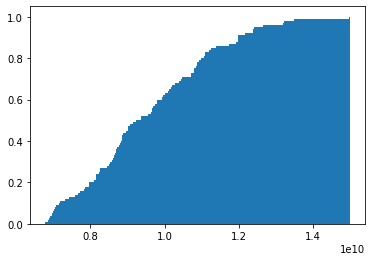

In [624]:
conf_int = get_confidence_interval(histo)

In [568]:
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i] - K))]

In [613]:
def find_min_max(conf_int_dict, conf_int):
    for key, val in conf_int_dict.items():
        if key >= conf_int:
            print(key, val)
            return key, val

In [61]:
find_min_max(conf_int, 0.0300)

NameError: name 'find_min_max' is not defined

In [615]:
find_min_max(conf_int, 0.97500)

0.9800000000000006 13483524958.579


(0.9800000000000006, 13483524958.579)

In [621]:
AL_df = create_state_df(ent_df, 'Alabama')

In [622]:
histo_AL = sample_100_times(AL_df)

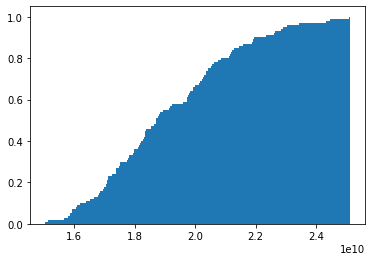

In [625]:
conf_int_AL = get_confidence_interval(histo_AL)

In [638]:
low_perc, low_num = find_min_max(conf_int_AL, 0.02500)

0.029999999999999995 15785670140.914


In [630]:
np.round(perc, 3)

0.03

In [639]:
high_perc, high_num = find_min_max(conf_int_AL, 0.97500)

0.9800000000000006 24469044519.696


In [640]:
state_lgbtq_df.at['Alabama', 'funding_low_est'] = low_num

In [642]:
state_lgbtq_df.at['Alabama', 'funding_low_perc'] = np.round(low_perc, 3)

In [643]:
state_lgbtq_df

,cbsa_code,funding,ipo,jobs_created,patents,ent,yes,funding_low_est,funding_low_perc
state,,,,,,,,,
Alabama,1482220.0,201424763,0.0,3304.0,151.0,86,2.8%,1.578567e+10,0.03
Alaska,0.0,22666224,0.0,60.0,14.0,5,3.4%,NaN,NaN
Arizona,11825260.0,3663843094,11.0,23266.0,222.0,311,3.9%,NaN,NaN
Arkansas,1312180.0,160538236,1.0,1634.0,13.0,51,3.5%,NaN,NaN
California,646908800.0,248938495973,296.0,7836301.0,15364.0,16444,4.0%,NaN,NaN
Colorado,15557460.0,7167643341,34.0,1041047.0,705.0,953,3.2%,NaN,NaN
Connecticut,4796840.0,2412297195,12.0,14499.0,150.0,251,3.4%,NaN,NaN
Delaware,2481940.0,482549247,0.0,1844.0,24.0,71,3.4%,NaN,NaN
District of Columbia,12070800.0,2707847711,2.0,20924.0,98.0,252,10.0%,NaN,NaN


In [598]:
# ERROR PRONE
# def get_confidence_interval(histo):
#     counts, bins, ignored = plt.hist(histo, bins=100)
#     dic_n = {}
#     bins = list(bins)
#     norm = [float(i)/sum(count) for i in count]
#     bins = bins[:-1]
#     x = np.cumsum(norm)
#     iterate = [[x[k], bins[k]] for k in range(100)]
#     return iterate

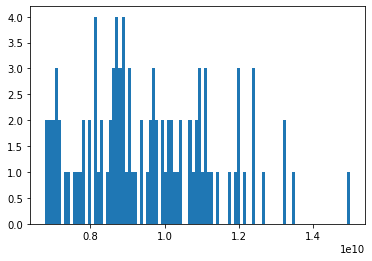

In [599]:
conf_int2 = get_confidence_interval(histo)

In [600]:
lower_limit = closest(x, 0.025)

In [601]:
lower_limit

0.03

In [602]:
upper_limit = closest(x, 0.975)

In [603]:
upper_limit

0.9700000000000006

In [604]:
conf_int2

[[0.01, 6790019951.0],
 [0.01, 6871947796.87],
 [0.01, 6953875642.74],
 [0.01, 7035803488.61],
 [0.01, 7117731334.48],
 [0.01, 7199659180.35],
 [0.01, 7281587026.22],
 [0.01, 7363514872.09],
 [0.02, 7445442717.96],
 [0.02, 7527370563.83],
 [0.02, 7609298409.7],
 [0.02, 7691226255.57],
 [0.02, 7773154101.440001],
 [0.03, 7855081947.31],
 [0.04, 7937009793.18],
 [0.04, 8018937639.05],
 [0.04, 8100865484.92],
 [0.04, 8182793330.79],
 [0.04, 8264721176.66],
 [0.04, 8346649022.530001],
 [0.04, 8428576868.4],
 [0.04, 8510504714.27],
 [0.04, 8592432560.14],
 [0.05, 8674360406.01],
 [0.05, 8756288251.880001],
 [0.05, 8838216097.75],
 [0.060000000000000005, 8920143943.62],
 [0.060000000000000005, 9002071789.49],
 [0.060000000000000005, 9083999635.36],
 [0.060000000000000005, 9165927481.23],
 [0.07, 9247855327.1],
 [0.07, 9329783172.970001],
 [0.08, 9411711018.84],
 [0.08, 9493638864.71],
 [0.09, 9575566710.58],
 [0.09, 9657494556.45],
 [0.09, 9739422402.32],
 [0.09, 9821350248.19],
 [0.09, 9903

In [584]:
find_min_max(conf_int2, 0.025)

2.0 13180391928.86


13180391928.86

In [585]:
find_min_max(conf_int, 0.975)

0.9800000000000005 13344247620.6


13344247620.6

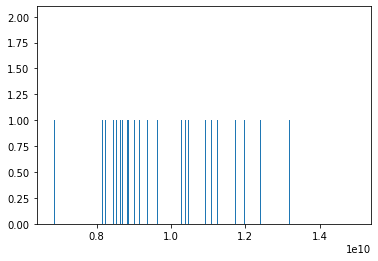

In [561]:
count, bins2, ignored = plt.hist(histo, bins = 1000)

In [562]:
dic_n = {}
for i in range(len(count)):
    dic_n[count[i]] = bins2[i]

In [563]:
bins2 = list(bins2)
norm = [float(i)/sum(count) for i in count]
bins2 = bins2[:-1]
x = np.cumsum(norm)
iterate = [[x[k], bins2[k]] for k in range(1000)]

{1.0: 14974611753.413, 0.0: 14966418968.826, 2.0: 11984245379.158}

In [551]:
bins2 = list(bins2)

In [552]:
norm = [float(i)/sum(count) for i in count]

In [553]:
bins2 = bins2[:-1]

In [554]:
x = np.cumsum(norm)

In [557]:
iterate = [[x[k], bins2[k]] for k in range(1000)]

In [558]:
iterate

[[0.01, 6790019951.0],
 [0.01, 6798212735.587],
 [0.01, 6806405520.174],
 [0.01, 6814598304.761],
 [0.01, 6822791089.348],
 [0.01, 6830983873.935],
 [0.01, 6839176658.522],
 [0.01, 6847369443.109],
 [0.02, 6855562227.696],
 [0.02, 6863755012.283],
 [0.02, 6871947796.87],
 [0.02, 6880140581.457],
 [0.02, 6888333366.044],
 [0.03, 6896526150.631],
 [0.04, 6904718935.218],
 [0.04, 6912911719.805],
 [0.04, 6921104504.392],
 [0.04, 6929297288.979],
 [0.04, 6937490073.566],
 [0.04, 6945682858.153],
 [0.04, 6953875642.74],
 [0.04, 6962068427.327],
 [0.04, 6970261211.914],
 [0.05, 6978453996.501],
 [0.05, 6986646781.088],
 [0.05, 6994839565.675],
 [0.060000000000000005, 7003032350.262],
 [0.060000000000000005, 7011225134.849],
 [0.060000000000000005, 7019417919.436],
 [0.060000000000000005, 7027610704.023],
 [0.07, 7035803488.61],
 [0.07, 7043996273.197],
 [0.08, 7052189057.784],
 [0.08, 7060381842.371],
 [0.09, 7068574626.958],
 [0.09, 7076767411.545],
 [0.09, 7084960196.132],
 [0.09, 70931529

In [ ]:
    count, bins, ignored = plt.hist(lst, bins = 30)
    norm = [float(i)/sum(count) for i in count]
    bins = bins[:-1]
    # Normalize
    x = np.cumsum(norm)
    iterate = [[x[k], bins[k]] for k in range(30)]

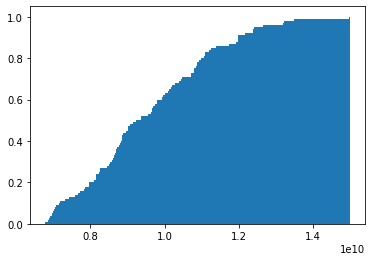

In [532]:
counts, bins, ignored = plt.hist(histo, cumulative=True, density=True, bins=1000)

In [533]:
dic_n = {}
for i in range(len(counts)):
    dic_n[counts[i]] = bins[i]

In [549]:

[[0.08, 6790019951.0],
 [0.12, 7063112770.566667],
 [0.13999999999999999, 7336205590.133333],
 [0.18, 7609298409.7],
 [0.22999999999999998, 7882391229.266666],
 [0.26999999999999996, 8155484048.833333],
 [0.36, 8428576868.4],
 [0.44999999999999996, 8701669687.966667],
 [0.49999999999999994, 8974762507.533333],
 [0.5199999999999999, 9247855327.1],
 [0.5999999999999999, 9520948146.666666],
 [0.6299999999999999, 9794040966.233334],
 [0.6799999999999999, 10067133785.8],
 [0.71, 10340226605.366667],
 [0.76, 10613319424.933334],
 [0.8300000000000001, 10886412244.5],
 [0.8600000000000001, 11159505064.066666],
 [0.8600000000000001, 11432597883.633333],
 [0.8800000000000001, 11705690703.2],
 [0.9200000000000002, 11978783522.766666],
 [0.9500000000000002, 12251876342.333332],
 [0.9600000000000002, 12524969161.9],
 [0.9600000000000002, 12798061981.466667],
 [0.9800000000000002, 13071154801.033333],
 [0.9900000000000002, 13344247620.6],
 [0.9900000000000002, 13617340440.166668],
 [0.9900000000000002, 13890433259.733334],
 [0.9900000000000002, 14163526079.3],
 [0.9900000000000002, 14436618898.866667],
 [1.0000000000000002, 14709711718.433334]]
dic_n

{0.01: 6847369443.109,
 0.02: 6888333366.044,
 0.03: 6896526150.631,
 0.04: 6970261211.914,
 0.05: 6994839565.675,
 0.060000000000000005: 7027610704.023,
 0.07: 7043996273.197,
 0.08: 7060381842.371,
 0.09: 7142309688.241,
 0.09999999999999999: 7166888042.002,
 0.10999999999999999: 7322550949.155,
 0.11999999999999998: 7429057148.786,
 0.12999999999999998: 7584720055.939,
 0.13999999999999999: 7674840686.396,
 0.15: 7723997393.918,
 0.16: 7830503593.549,
 0.17: 7838696378.136,
 0.18000000000000002: 7961588146.941,
 0.19000000000000003: 7969780931.528,
 0.20000000000000004: 8100865484.92,
 0.21000000000000005: 8133636623.268,
 0.22000000000000006: 8141829407.855,
 0.23000000000000007: 8158214977.029,
 0.24000000000000007: 8223757253.725,
 0.25000000000000006: 8256528392.073,
 0.26000000000000006: 8264721176.66,
 0.2700000000000001: 8436769652.9869995,
 0.2800000000000001: 8502311929.683001,
 0.2900000000000001: 8518697498.857,
 0.3000000000000001: 8584239775.5529995,
 0.3100000000000001

In [500]:
len(sample_list_CA)

631

In [498]:
np.array(sample_list_CA)

array([  8750000,   2467973,   1321429,  80380067,    124163,   1566667,
               0,    729167,    729167,  50750000, 128050000,   5800000,
          475000,         0,    475000,         0,     28500,    910000,
         5115947,   3270010,    445379,   4000000,         0,  37000000,
        26500000,  82500000,  52553098,   5000000,   6321504,   9733333,
          600000,  12857143,   1570195,    500000,   1825000,   2500000,
           13333,   2684615,  47000000,  10447903,  10447903,  22500000,
         3877920,         0,  11517750,   3971789,         0,    230000,
          307500,  19500000,   1000000,  76250000,  23520763,         0,
         3500000,         0,   2500000,  10000000,   1666667,         0,
          166667,         0,   2500000,   5083333,  11600000,    500000,
          680000,  10500000,         0,   2833333,   1000000,  31500000,
         9257750,   9257750,  24750000,   4515993,   4750000,    167400,
         5962500,  11250000,   6666667,    187500, 

In [499]:
counts, bins, bars = np.array(sample_list_CA).hist(cumulative=True, density=True, bins=100)

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

In [478]:
CA_df.iloc[68,:]

cbsa_code                                          41860
city                                              Dublin
company_name                                  SirionLabs
crunchbase_permalink                          sirionlabs
crunchbase_uuid         276fb10fd9e06bfd2daf4c5d34f06ea4
csa_code                                           488.0
funding                                          8475000
gender                                              Male
ipo                                                False
jobs_created                                          50
lgbtq                                                NaN
name                                       Claude Marais
patents                                                0
race_ethnicity                                       NaN
startout_id                                          NaN
state                                         California
state_abbrev                                          CA
ent                            

In [ ]:
gs://impact-index-shared-resources/data/external/gallup_lgbt_poll.txt